In [1]:
!pip install pretrainedmodels
!unzip -qq /kaggle/input/panda256/train

     |████████████████████████████████| 58 kB 2.4 MB/s 
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60962 sha256=09a666864761cfeb4ac445de9f35ab2b05ea2092ccb024106615f96efdf33d8b
  Stored in directory: /root/.cache/pip/wheels/ed/27/e8/9543d42de2740d3544db96aefef63bda3f2c1761b3334f4873
Successfully built pretrainedmodels


In [2]:
import os
import numpy as np
import pandas as pd

import torch
import cv2
from tqdm import tqdm
import albumentations
import pretrainedmodels

import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.utils.data as data_utils
from torch.nn import functional as F

from sklearn.metrics import cohen_kappa_score
from fastai.layers import LabelSmoothingCrossEntropy
from matplotlib import pyplot as plt

In [3]:
BASE_DIR = '/kaggle/input/panda256'
DATA_DIR = '/kaggle/working/kaggle/working/train_images'
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
BATCH_SIZE = 16
EPOCHS = 25
LEARNING_RATE = 0.02

In [4]:
train_df = pd.read_csv(os.path.join(BASE_DIR, 'train.csv'))
train_df.head()

,image_id,data_provider,isup_grade,gleason_score,kfold
0,1b04602fffd6117606d1a05efa96daaf_4,radboud,5,5+4,3
1,e2726cffee3499287c6f87b561dd228d_10,radboud,5,5+4,0
2,d908ac781e507048dca9b45d93fcec44_1,karolinska,3,4+3,4
3,56e5d931e0c46a942e76aaa95485b9cd_6,radboud,5,4+5,1
4,effe920ec2c4a10fe08d237a806d04d5_1,karolinska,0,0+0,0


In [5]:
# train_df = train_df.sample(frac=0.1)

In [6]:
train_df.shape

(92427, 5)

In [7]:
train_df['gleason_score'].unique()

array(['5+4', '4+3', '4+5', '0+0', '3+3', '3+4', '4+4', 'negative', '5+5', '3+5', '5+3'], dtype=object)

Gleason scores "0+0" and "negative" are same, so let's first replace "negative" with "0+0" for consistency.

In [8]:
train_df['gleason_score'] = train_df['gleason_score'].str.replace('negative', '0+0')
train_df['gleason_score'].unique()

array(['5+4', '4+3', '4+5', '0+0', '3+3', '3+4', '4+4', '5+5', '3+5', '5+3'], dtype=object)

Gleason score has string data-type, we need to convert it in categorical features before feeding it into our model.

In [9]:
train_df['gleason_score'] = train_df['gleason_score'].astype('category')
train_df.dtypes

image_id           object
data_provider      object
isup_grade          int64
gleason_score    category
kfold               int64
dtype: object

In [10]:
mappings = dict(enumerate(train_df['gleason_score'].cat.categories))
mappings

{0: '0+0',
 1: '3+3',
 2: '3+4',
 3: '3+5',
 4: '4+3',
 5: '4+4',
 6: '4+5',
 7: '5+3',
 8: '5+4',
 9: '5+5'}

In [11]:
train_df['gleason_score'] = train_df['gleason_score'].cat.codes

In [12]:
train_df.dtypes

image_id         object
data_provider    object
isup_grade        int64
gleason_score      int8
kfold             int64
dtype: object

In [13]:
print(f'Number of classes: {len(train_df["gleason_score"].unique())}')

Number of classes: 10


## Defining the dataset

In [14]:
class PandaDataset(Dataset):
    """Custom dataset for PANDA"""
    
    def __init__(self, df, folds, mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)):
        self.df = df
        self.df = self.df[self.df.kfold.isin(folds)].reset_index(drop=True)
        
        # In case of validation dataset, don't apply transformations
        if len(folds) == 1:
            self.aug = albumentations.Compose([
                albumentations.Normalize(mean, std, always_apply=True)
            ])
        else:
            self.aug = albumentations.Compose([
                albumentations.ShiftScaleRotate(shift_limit=0.0625,
                                               scale_limit=0.15, 
                                               rotate_limit=10,
                                               p=0.9),
                albumentations.HorizontalFlip(p=0.5),
                albumentations.VerticalFlip(p=0.5),
                albumentations.Normalize(mean, std, always_apply=True)
            ])
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        image_id = self.df.loc[index]['image_id']
        image = cv2.imread(os.path.join(DATA_DIR, f'{image_id}.jpg'))
        image = self.aug(image=image)['image']
        
        # Convert from NHWC to NCHW as pytorch expects images in NCHW format
        image = np.transpose(image, (2, 0, 1))
        
        # For now, just return image and ISUP grades
        return image, self.df.loc[index]['gleason_score']

In [15]:
train_dataset = PandaDataset(train_df, folds=[1, 2, 3, 4])
train_loader = data_utils.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

val_dataset = PandaDataset(train_df, folds=[0])
val_loader = data_utils.DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [16]:
class DenseNet121(nn.Module):
    """
    Define DenseNet121 model with 10 output classes based on gleason scores
    """
    def __init__(self, pretrained):
        super(DenseNet121, self).__init__()
        if pretrained is True:
            self.model = pretrainedmodels.__dict__["densenet121"](pretrained="imagenet")
        else:
            self.model = pretrainedmodels.__dict__["densenet121"](pretrained=None)
        
        self.l0 = nn.Linear(1024, 10)

    def forward(self, x):
        bs, _, _, _ = x.shape
        x = self.model.features(x)
        x = F.adaptive_avg_pool2d(x, 1).reshape(bs, -1)
        l0 = self.l0(x)
        return l0

In [17]:
model = DenseNet121(pretrained=True)
model.to(DEVICE)

Downloading: "http://data.lip6.fr/cadene/pretrainedmodels/densenet121-fbdb23505.pth" to /root/.cache/torch/checkpoints/densenet121-fbdb23505.pth


DenseNet121(
  (model): DenseNet(
    (features): Sequential(
      (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu0): ReLU(inplace=True)
      (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (denseblock1): _DenseBlock(
        (denselayer1): _DenseLayer(
          (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu1): ReLU(inplace=True)
          (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu2): ReLU(inplace=True)
          (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        )
        (denselayer2): _DenseLayer(
          (norm1): BatchNorm2d(96, eps=1e-05, momentum=0

In [18]:
optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE)
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=False, threshold=0.0001, threshold_mode='rel', cooldown=0, min_lr=0.00001, eps=1e-08)
criterion = LabelSmoothingCrossEntropy(0.1)

In [19]:
# Make use of parallel GPUs if available
if torch.cuda.device_count() > 1:
    model = nn.DataParallel(model)

In [20]:
def get_accuracy(preds, targets):
    assert len(preds) == len(targets)
    
    total = len(preds)
    _, preds = torch.max(preds.data, axis=1)

    correct = (preds == targets).sum().item()
    return correct / total

In [21]:
val_acc_list = []

for epoch in range(EPOCHS):
    model.train()
    for i, (x_train, y_train) in tqdm(enumerate(train_loader), total=int(len(train_dataset)/train_loader.batch_size)):
        x_train = x_train.to(DEVICE, dtype=torch.float32)/255
        y_train = y_train.to(DEVICE, dtype=torch.long)
        
        
        # Forward pass
        preds = model(x_train)
        loss = criterion(preds, y_train)
        
        # Backpropagate
        optimizer.zero_grad()  # Reason: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch
        loss.backward()
        optimizer.step()
    
    lr_scheduler.step(loss.item())

    # Calculate validation accuracy after each epoch
    # Predict on validation set
    
    with torch.no_grad():
        model.eval()

        correct = 0
        val_size = len(val_loader)
        for x_val, y_val in tqdm(val_loader, total=int(len(val_dataset)/val_loader.batch_size)):

            x_val = x_val.to(DEVICE, dtype=torch.float32)/255
            y_val = y_val.to(DEVICE, dtype=torch.long)

            val_preds = model(x_val)
            _, preds = torch.max(val_preds.data, axis=1)
            correct += (preds == y_val).sum().item()

        val_acc = correct / len(val_dataset)
        val_acc_list.append(val_acc)

    print('Epoch [{}/{}], Loss: {:.4f}, Validation accuracy: {:.2f}%'
          .format(epoch + 1, EPOCHS, loss.item(), val_acc * 100))

4622it [10:52,  7.08it/s]
1156it [01:54, 10.07it/s]
  0%|          | 1/4621 [00:00<10:48,  7.13it/s]

Epoch [1/25], Loss: 1.8858, Validation accuracy: 37.00%


4622it [10:58,  7.02it/s]
1156it [01:49, 10.52it/s]
  0%|          | 0/4621 [00:00<?, ?it/s]

Epoch [2/25], Loss: 1.3966, Validation accuracy: 34.07%


4622it [10:33,  7.30it/s]
1156it [01:50, 10.42it/s]                          
  0%|          | 1/4621 [00:00<10:15,  7.51it/s]

Epoch [3/25], Loss: 1.2321, Validation accuracy: 38.18%


1156it [01:48, 10.63it/s]
  0%|          | 1/4621 [00:00<10:29,  7.34it/s]

Epoch [6/25], Loss: 1.4684, Validation accuracy: 44.09%


4622it [10:23,  7.42it/s]
1156it [01:49, 10.52it/s]                          
  0%|          | 1/4621 [00:00<10:12,  7.54it/s]

Epoch [7/25], Loss: 2.0875, Validation accuracy: 43.95%


1156it [01:52, 10.30it/s]                          
  0%|          | 1/4621 [00:00<10:24,  7.40it/s]

Epoch [10/25], Loss: 1.7181, Validation accuracy: 47.77%


4622it [10:55,  7.05it/s]
1156it [01:47, 10.76it/s]                          
  0%|          | 1/4621 [00:00<09:59,  7.71it/s]

Epoch [22/25], Loss: 1.8464, Validation accuracy: 51.19%


1156it [01:47, 10.74it/s]
  0%|          | 1/4621 [00:00<10:18,  7.47it/s]

Epoch [24/25], Loss: 1.3415, Validation accuracy: 51.30%


 49%|████▉     | 2268/4621 [05:01<05:04,  7.73it/s]

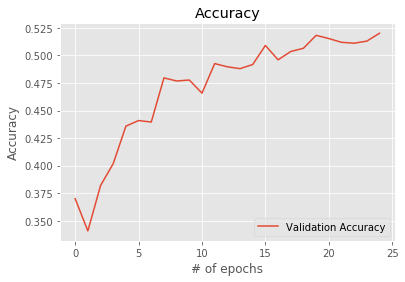

In [22]:
plt.style.use('ggplot')
plt.figure()
plt.plot(np.arange(0, len(val_acc_list)), val_acc_list, label='Validation Accuracy')

plt.title('Accuracy')
plt.xlabel('# of epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

In [23]:
# Remove all the images from working directory to prevent them from kernel's output
!rm -rf *

In [24]:
torch.save(model.state_dict(), 'densenet121_256_gs_fold0.pth')